In [1]:
import torch
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from transformers import BertTokenizer, BertForSequenceClassification, AdamW

In [2]:
df = pd.read_excel('/content/merged_positive_and_negative_reviews.xlsx')
df

,Review,Label
0,الصراحة شهادتي فيهم مجروحة فندق اكثر من استثنا...,إيجابي
1,الطاقم متعاون والمكان نظيف جدا ومرتب وراقي,إيجابي
2,المطعم مميز جدا واشكر القائمين عليه وعلى اخلا...,إيجابي
3,الموقع,إيجابي
4,الموقع والرفاهيه,إيجابي
...,...,...
61421,الشبابيك يدخل منها ضوء عالي مزعج جداً اثناء النوم,سلبي
61422,نقطه صغيره استغربتها مع نظافة المكان الجيده ال...,سلبي
61423,السعر مرتفع قليلاً,سلبي
61424,ولا شي طبعا,سلبي


In [3]:
# Convert 'Label' column to 1 and 0
df['Label'] = df['Label'].map({'إيجابي': 1, 'سلبي': 0})

In [4]:
df

,Review,Label
0,الصراحة شهادتي فيهم مجروحة فندق اكثر من استثنا...,1
1,الطاقم متعاون والمكان نظيف جدا ومرتب وراقي,1
2,المطعم مميز جدا واشكر القائمين عليه وعلى اخلا...,1
3,الموقع,1
4,الموقع والرفاهيه,1
...,...,...
61421,الشبابيك يدخل منها ضوء عالي مزعج جداً اثناء النوم,0
61422,نقطه صغيره استغربتها مع نظافة المكان الجيده ال...,0
61423,السعر مرتفع قليلاً,0
61424,ولا شي طبعا,0


In [6]:
# Assuming your CSV file has columns 'text' and 'label'
data = list(zip(df['Review'].astype(str),df['Label'].astype(str)))  # Ensure the 'text' and 'label' columns are treated as strings

In [7]:
# Split the dataset into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)

In [8]:
# Define a custom dataset class
class SentimentDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text, label = self.data[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(int(label))  # Assuming labels are integers representing the class index
        }

In [9]:
# Load the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=2)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
# Create datasets and dataloaders
train_dataset = SentimentDataset(train_data, tokenizer)
test_dataset = SentimentDataset(test_data, tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [11]:
# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [12]:
# Training loop
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
num_epochs = 6

In [13]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    for batch in tqdm(train_dataloader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        inputs = {key: val.to(device) for key, val in batch.items() if key != 'label'}
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(**inputs, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Get model predictions
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_preds)

    # Print loss and accuracy
    avg_loss = total_loss / len(train_dataloader)
    print(f'Epoch {epoch + 1}/{num_epochs} - Average Loss: {avg_loss:.4f} - Accuracy: {accuracy:.4f}')

Epoch 1/6: 100%|██████████| 5375/5375 [19:23<00:00,  4.62it/s]


Epoch 1/6 - Average Loss: 0.2840 - Accuracy: 0.8891


Epoch 2/6: 100%|██████████| 5375/5375 [19:27<00:00,  4.60it/s]


Epoch 2/6 - Average Loss: 0.2330 - Accuracy: 0.9150


Epoch 3/6: 100%|██████████| 5375/5375 [19:27<00:00,  4.60it/s]


Epoch 3/6 - Average Loss: 0.2087 - Accuracy: 0.9229


Epoch 4/6: 100%|██████████| 5375/5375 [19:26<00:00,  4.61it/s]


Epoch 4/6 - Average Loss: 0.1900 - Accuracy: 0.9310


Epoch 5/6: 100%|██████████| 5375/5375 [19:26<00:00,  4.61it/s]


Epoch 5/6 - Average Loss: 0.1742 - Accuracy: 0.9381


Epoch 6/6: 100%|██████████| 5375/5375 [19:27<00:00,  4.61it/s]


Epoch 6/6 - Average Loss: 0.1638 - Accuracy: 0.9407


In [14]:
# Evaluation
model.eval()
predictions, true_labels = [], []
for batch in tqdm(test_dataloader, desc='Evaluating'):
    inputs = {key: val.to(device) for key, val in batch.items() if key != 'label'}
    labels = batch['label'].to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    predictions.extend(torch.argmax(logits, dim=1).cpu().numpy())
    true_labels.extend(labels.cpu().numpy())

Evaluating: 100%|██████████| 2304/2304 [02:11<00:00, 17.52it/s]


In [15]:
# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.9138


In [16]:
# Save model locally in Colab
model.save_pretrained('/content/sentimental_analysis_model')
tokenizer.save_pretrained('/content/tokenizer')

('/content/tokenizer/tokenizer_config.json',
 '/content/tokenizer/special_tokens_map.json',
 '/content/tokenizer/vocab.txt',
 '/content/tokenizer/added_tokens.json')

In [17]:
# Calculate confusion matrix and classification report
conf_matrix = confusion_matrix(true_labels, predictions)
class_report = classification_report(true_labels, predictions)

# Display confusion matrix and classification report
print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

Confusion Matrix:
[[8481  844]
 [ 745 8358]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.91      0.91      9325
           1       0.91      0.92      0.91      9103

    accuracy                           0.91     18428
   macro avg       0.91      0.91      0.91     18428
weighted avg       0.91      0.91      0.91     18428



Testing Dataset Label Distribution:
0    9325
1    9103
Name: count, dtype: int64
True: 1, Predicted: 1
True: 1, Predicted: 1
True: 1, Predicted: 1
True: 1, Predicted: 1
True: 1, Predicted: 1
True: 1, Predicted: 1
True: 0, Predicted: 0
True: 0, Predicted: 0
True: 0, Predicted: 0
True: 1, Predicted: 0


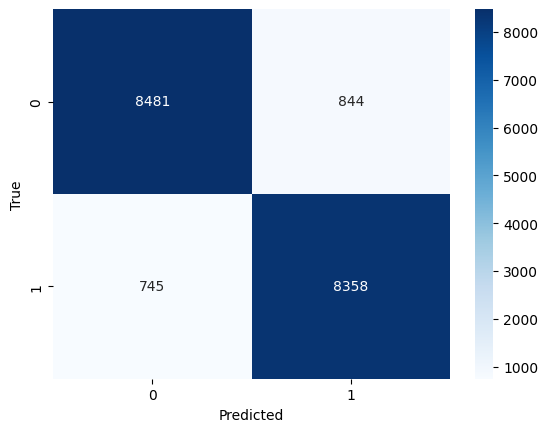

In [18]:
# Print the distribution of labels in the testing dataset
print("Testing Dataset Label Distribution:")
print(pd.Series(true_labels).value_counts())

# Print true labels and predicted labels for a small sample
for true, pred in zip(true_labels[:10], predictions[:10]):
    print(f"True: {true}, Predicted: {pred}")

# Plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
from google.colab import files

# Specify the file path in Colab
file_path = '/content/sentimental_analysis_model/model.safetensors'

# Download the file
files.download(file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
import shutil

# Define the path to the file and the destination in Google Drive
file_path = '/content/sentimental_analysis_model/model.safetensors'
destination_folder = '/content/drive/MyDrive/Booking Reviews Model2'

# Copy the file to the destination folder in Google Drive
shutil.copy(file_path, destination_folder)

'/content/drive/MyDrive/Booking Reviews Model2/model.safetensors'